# PROJET DATASCIENTEST
## EXPLORATION ET DATA VISUALISATION

In [4]:
# Augmente la taille du notebook pour occuper toute la page
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#Importation des modules utilisés
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nba_api

sns.set_theme()

In [143]:
# Chargement des jeux de données
# Note: les chemins des fichiers sont ceux en local sur mon pc
#       A modifier si nécessaire
shot_data = pd.read_csv("../Data/NBA Shot Locations 1997 - 2020.csv") # Données de chaque tir (distance, temps restant, période du match, etc.), contient la variable cible Shot Made Flag
player_data = pd.read_csv("../Data/Players.csv", index_col=0) # Données individuelles de chaque joueur (taille, poids, date et lieu de naissance, etc.)
pbp_data = pd.read_csv('../Data/pbp_concat.csv') # Données détaillées de chaque action (pas seulement les tirs) par match

In [144]:
# On récupère des noms et IDs uniques des joueurs avec nba_pi
from nba_api.stats.static import players
all_players = players.get_players()
player_id = [player_info['id'] for player_info in all_players]
player_first_name = [player_info['first_name'] for player_info in all_players]
player_last_name = [player_info['last_name'] for player_info in all_players]
player_full_name = [player_info['full_name'] for player_info in all_players]

# Fonction qui associe l'ID du joueur à parti de son nom et prénom
# si ils se trouvent dans la liste des joueurs connus
def name_to_player_id(full_name):
    if full_name in player_full_name:
        return player_id[player_full_name.index(full_name)]
    else:
        return np.nan
    
# On ajoute l'ID des joueurs à player_data
player_data['Player ID'] = player_data['Player'].astype('str').apply(name_to_player_id)
player_data = player_data.dropna(axis=0, subset=['Player ID'])
player_data['Player ID'] = player_data['Player ID'].astype(int)

In [20]:
# On récupère la liste des 1000 meilleurs scoreurs de tout les temps en terme de 
# total de points marqués sur les saisons régulières avec nba_api
from nba_api.stats.endpoints import AllTimeLeadersGrids
all_time_leader_grid = AllTimeLeadersGrids(topx=1000, per_mode_simple='Totals', season_type='Regular Season')
best_scorer_data = all_time_leader_grid.pts_leaders.get_data_frame()

In [112]:
# On enlève les 2 premières colonnes inutiles dans pbp_data
print(pbp_data.info())
pbp_data.drop(pbp_data.columns[:2], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10389755 entries, 0 to 10389754
Data columns (total 35 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0.1               int64  
 1   Unnamed: 0                 int64  
 2   EVENTMSGACTIONTYPE         int64  
 3   EVENTMSGTYPE               int64  
 4   EVENTNUM                   int64  
 5   GAME_ID                    int64  
 6   HOMEDESCRIPTION            object 
 7   NEUTRALDESCRIPTION         float64
 8   PCTIMESTRING               object 
 9   PERIOD                     int64  
 10  PERSON1TYPE                float64
 11  PERSON2TYPE                int64  
 12  PERSON3TYPE                int64  
 13  PLAYER1_ID                 int64  
 14  PLAYER1_NAME               object 
 15  PLAYER1_TEAM_ABBREVIATION  object 
 16  PLAYER1_TEAM_CITY          object 
 17  PLAYER1_TEAM_ID            float64
 18  PLAYER1_TEAM_NICKNAME      object 
 19  PLAYER2_ID                 int64  
 20  

In [113]:
# On sélectionne uniquement les actions correspondants à des tirs dans les données play-by-play
# pour pouvoir les matcher avec shot_data
pbp_data = pbp_data[pbp_data['HOMEDESCRIPTION'].str.contains('shot|shoot',regex=True,case=False) | 
                    pbp_data['VISITORDESCRIPTION'].str.contains('shot|shoot',regex=True,case=False)]

In [146]:
# On ajoute les données individuelles de chaque joueur dans shot_data 
# en réalisant une fusion sur la colonne Player ID
shot_data = shot_data.merge(player_data, on='Player ID', how = 'inner')
shot_data.drop('Player', axis=1, inplace=True) # colonne redondante avec Player Name

In [110]:
shot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4476237 entries, 0 to 4476236
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Game ID            int64  
 1   Game Event ID      int64  
 2   Player ID          int64  
 3   Player Name        object 
 4   Team ID            int64  
 5   Team Name          object 
 6   Period             int64  
 7   Minutes Remaining  int64  
 8   Seconds Remaining  int64  
 9   Action Type        object 
 10  Shot Type          object 
 11  Shot Zone Basic    object 
 12  Shot Zone Area     object 
 13  Shot Zone Range    object 
 14  Shot Distance      int64  
 15  X Location         int64  
 16  Y Location         int64  
 17  Shot Made Flag     int64  
 18  Game Date          int64  
 19  Home Team          object 
 20  Away Team          object 
 21  Season Type        object 
 22  height             float64
 23  weight             float64
 24  collage            object 
 25  born              

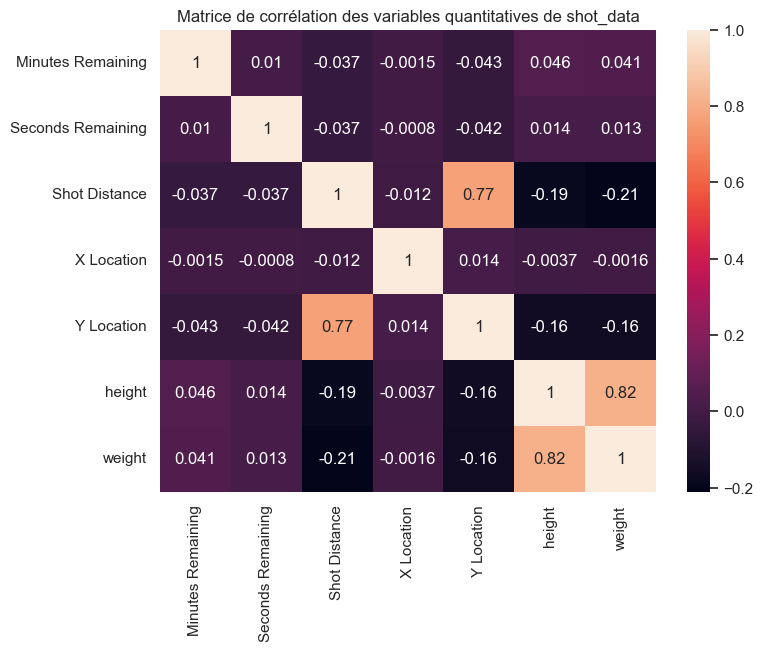

In [151]:
# Affichage de la matrice de corrélation pour les variables quantitatives de shot_data
variables_quantitatives = ['Minutes Remaining', 'Seconds Remaining', 'Shot Distance',
                           'X Location', 'Y Location', 'height', 'weight']
corr = shot_data[variables_quantitatives].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)
plt.title("Matrice de corrélation des variables quantitatives de shot_data")
plt.show()

In [148]:
# On récupère les données des joueurs et de leurs tirs uniquement pour les 20 meilleurs scoreurs encore actifs
# en fusionnant avec best_scorer_data
player_data_top20 = player_data.merge(best_scorer_data[best_scorer_data['IS_ACTIVE_FLAG']=='Y'].head(20), 
                                      how='inner', left_on='Player ID', right_on='PLAYER_ID')
shot_data_top20 = shot_data.merge(best_scorer_data[best_scorer_data['IS_ACTIVE_FLAG']=='Y'].head(20),
                                  how='inner', left_on='Player ID', right_on='PLAYER_ID')

# On supprime les colonnes redondantes résultant de la fusion
player_data_top20.drop(['PLAYER_ID','PLAYER_NAME'], axis=1, inplace=True)
shot_data_top20.drop(['PLAYER_ID','PLAYER_NAME'], axis=1, inplace=True)

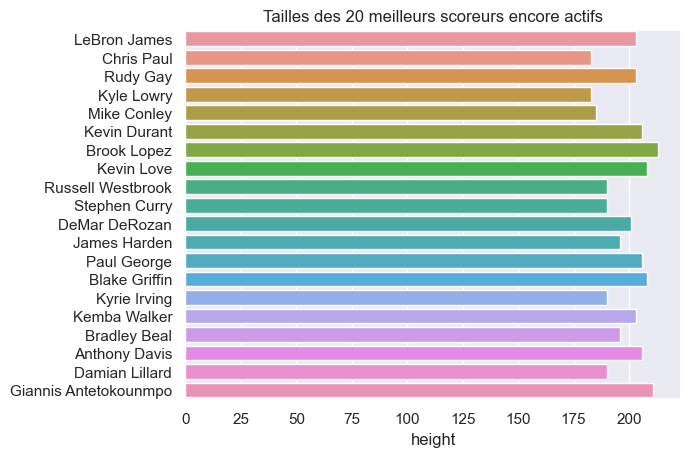

In [152]:
# Affichage des tailles des 20 meilleurs joueurs
sns.barplot(x='height', y='Player', data=player_data_top20)
plt.ylabel(None)
plt.title("Tailles des 20 meilleurs scoreurs encore actifs")
plt.show()

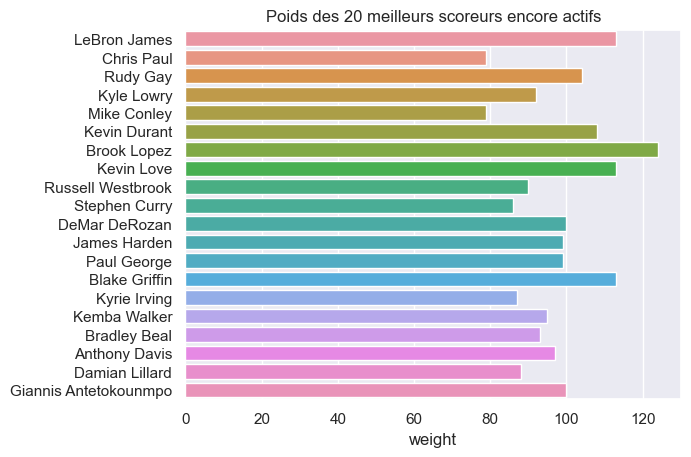

In [153]:
# Affichage des poids des 20 meilleurs joueurs
sns.barplot(x='weight', y='Player', data=player_data_top20)
plt.ylabel(None)
plt.title("Poids des 20 meilleurs scoreurs encore actifs")
plt.show()

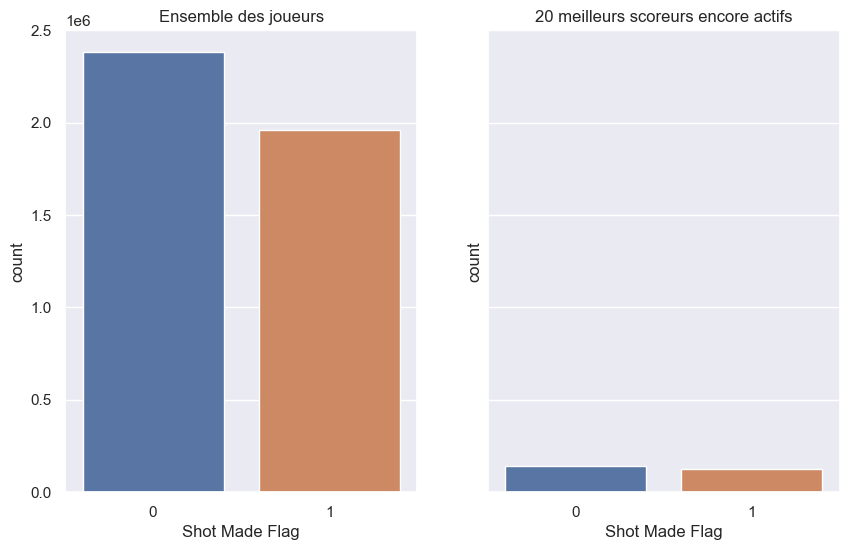

In [160]:
# Nombre de tirs réussis et ratés pour l'ensemble des joueurs et pour les 20 meilleurs scoreurs
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharey=True)

sns.countplot(x='Shot Made Flag', data=shot_data, ax=ax1)
ax1.set_title("Ensemble des joueurs")

sns.countplot(x='Shot Made Flag', data=shot_data_top20, ax=ax2)
ax2.set_title("20 meilleurs scoreurs encore actifs")

plt.show()

In [166]:
# Calcul des proportions des tirs ratés et réussis pour l'ensemble des joueurs
counts = shot_data['Shot Made Flag'].value_counts()
frac_out = counts[0]/len(shot_data)
frac_in = counts[1]/len(shot_data)
print("Ensemble des joueurs:")
print("  Tirs réussis = {0:.2f} %".format(100*frac_in))
print("  Tirs ratés = {0:.2f} %".format(100*frac_out))

# Même chose mais uniquement pour les 20 meilleurs scoreurs
counts = shot_data_top20['Shot Made Flag'].value_counts()
frac_out = counts[0]/len(shot_data_top20)
frac_in = counts[1]/len(shot_data_top20)
print("20 meilleurs scoreurs:")
print("  Tirs réussis = {0:.2f} %".format(100*frac_in))
print("  Tirs ratés = {0:.2f} %".format(100*frac_out))

Ensemble des joueurs:
  Tirs réussis = 45.14 %
  Tirs ratés = 54.86 %
20 meilleurs scoreurs:
  Tirs réussis = 46.36 %
  Tirs ratés = 53.64 %


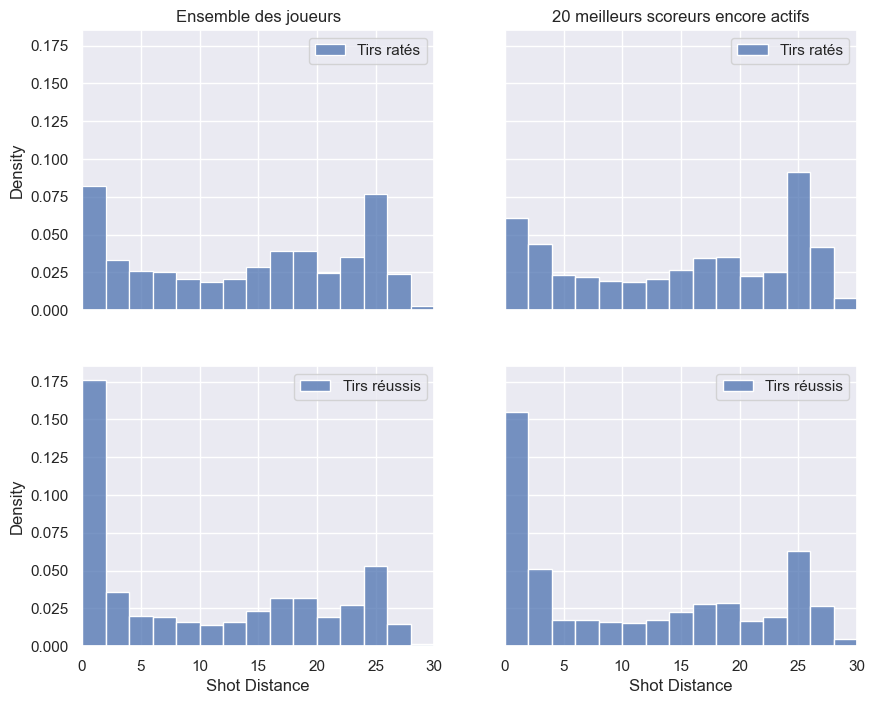

In [174]:
# Affichage de la distribution de la distance des tirs ratés et réussis
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=True, sharey=True)
ax1, ax2 = axs[0]
ax3, ax4 = axs[1]

bins = np.arange(0,52,2)

sns.histplot(x='Shot Distance', bins=bins, stat='density', 
             data=shot_data[shot_data['Shot Made Flag']==0], ax=ax1, label='Tirs ratés')
ax1.set_title('Ensemble des joueurs')
ax1.set_xlim(0,30)
ax1.legend()

sns.histplot(x='Shot Distance', bins=bins, stat='density', 
             data=shot_data_top20[shot_data_top20['Shot Made Flag']==0], ax=ax2, label='Tirs ratés')
ax2.set_title('20 meilleurs scoreurs encore actifs')
ax2.set_xlim(0,30)
ax2.legend()

sns.histplot(x='Shot Distance', bins=bins, stat='density', 
             data=shot_data[shot_data['Shot Made Flag']==1], ax=ax3, label='Tirs réussis')
ax3.legend()

sns.histplot(x='Shot Distance', bins=bins, stat='density', 
             data=shot_data_top20[shot_data_top20['Shot Made Flag']==1], ax=ax4, label='Tirs réussis')
ax4.legend()

plt.show()

In [157]:
# On crée la variable Time remaining qui indique le temps restant du quart-temps actuel 
# pour chaque tir (en secondes)
time_remaining = shot_data['Minutes Remaining']*60+shot_data['Seconds Remaining']
shot_data['Time remaining'] = time_remaining

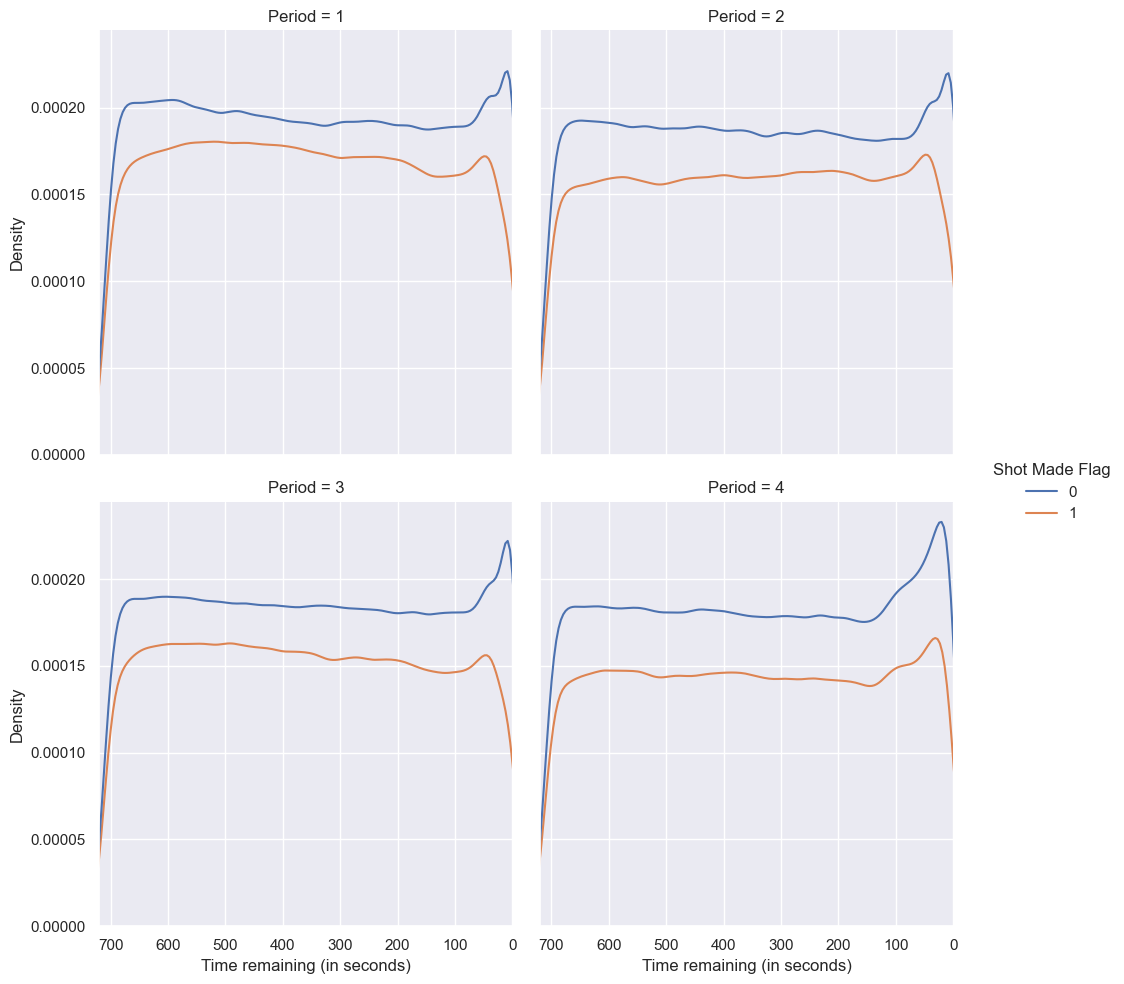

In [158]:
# Affichage de la proportion de tirs ratés et réussis par l'ensemble des joueurs
# en fonction du temps restant pour chaque quart-temps
dp = sns.displot(x='Time remaining', hue='Shot Made Flag', 
            kind='kde', col='Period', col_wrap=2, 
            data=shot_data[shot_data['Period']<=4])
for ax in dp.axes:
    ax.set_xlim(720,0)
    ax.set_xlabel('Time remaining (in seconds)')
plt.show()

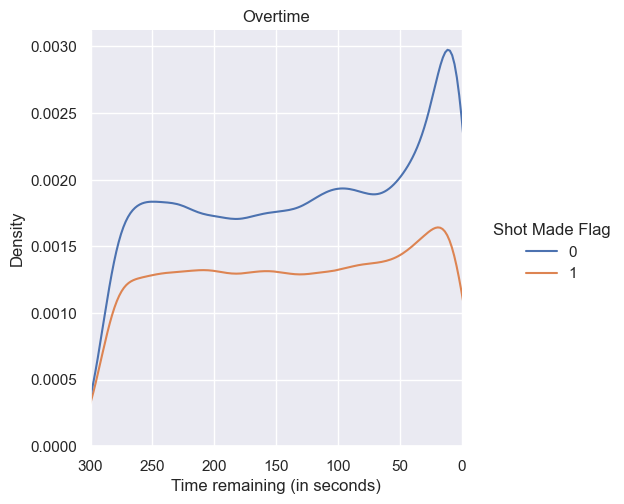

In [159]:
# Pareil que la précédente figure mais pour les prolongations
sns.displot(x='Time remaining', hue='Shot Made Flag', 
            kind='kde', 
            data=shot_data[shot_data['Period']>=5])
plt.xlim(300,0)
plt.xlabel('Time remaining (in seconds)')
plt.title('Overtime')
plt.show()

In [176]:
# On discrétise la taille des joueurs
bins = [160,200,240]
labels = ['<=200', '>200']
discrete_height = pd.cut(shot_data['height'], bins=bins, labels=labels)

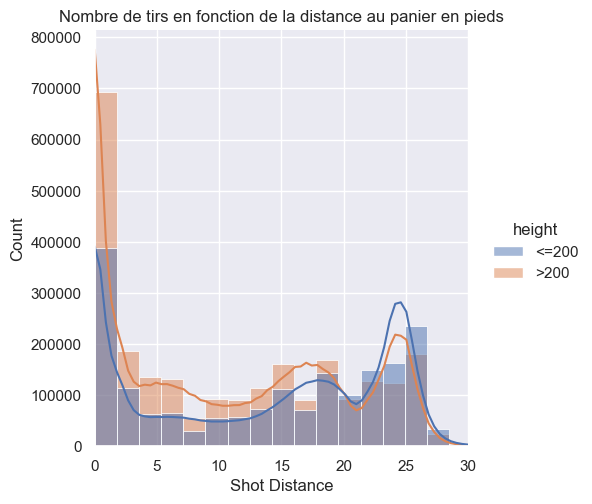

In [177]:
# Affichage de nombre de tirs en fonction de la distance
sns.displot(x='Shot Distance', kind='hist', kde=True, bins=50, hue=discrete_height, data=shot_data)
plt.xlim(0,30)
plt.title("Nombre de tirs en fonction de la distance au panier en pieds")
plt.show()

In [180]:
# Test de correlation de pearson entre la taille d'un joueur et la distance du tir
from scipy.stats import pearsonr

r, p = pearsonr(shot_data['height'], shot_data['Shot Distance'])

print("Résultat du test de corrélation de Pearson entre la taille d'un joueur et la distance de ses tirs")
print("Coefficient de correlation = ", r)
print("p_value = ", p)

Résultat du test de corrélation de Pearson entre la taille d'un joueur et la distance de ses tirs
Coefficient de correlation =  -0.18563341147377913
p_value =  0.0


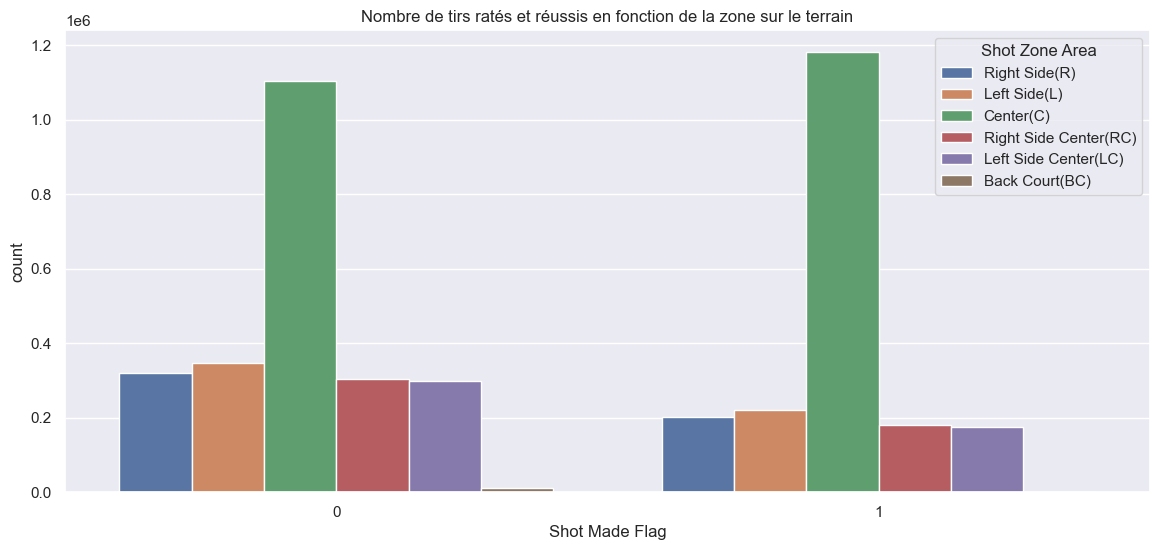

In [183]:
# Affichage du nombre de tirs ratés et réussis en fonction de la zone sur le terrain
plt.figure(figsize=(14,6))
sns.countplot(x='Shot Made Flag', hue='Shot Zone Area', data=shot_data)
plt.title("Nombre de tirs ratés et réussis en fonction de la zone sur le terrain")
plt.show()